In [1]:
# ====================================================
# Library import
# ====================================================
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import astropy_mpl_style
from astropy.wcs import WCS
plt.style.use(astropy_mpl_style)

## Let's run a simple object finder on our image,
## and collect the catalog.
import numpy as np
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats

from scipy import sparse
from scipy.sparse import csr_matrix

from random import randint
from time import sleep

from spectral_cube import SpectralCube
from astroquery.esasky import ESASky
from astroquery.utils import TableList
from reproject import reproject_interp
import astropy.units as u

from pyspark.sql import SQLContext, SparkSession, HiveContext
from pyspark import StorageLevel

from pyspark import SparkFiles

from pyspark.sql import functions as F
import pyspark.sql.functions as f

from pyspark.sql.functions import randn, monotonically_increasing_id, row_number, desc, udf, col, lit
from pyspark.sql.functions import broadcast
from pyspark.sql.types import ArrayType, FloatType,IntegerType, DataType, DoubleType,Row, BooleanType

"""
Set the Spark datatypes
"""
iType=IntegerType()
dType=DoubleType()
fType=FloatType()

from pyspark.sql.functions import pandas_udf, PandasUDFType

from pyspark.sql.window import Window

from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import SparseVector, DenseVector,VectorUDT

from datetime import datetime
import time
import logging
import sys



maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/cache
maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/config
maindir is /home/hduser/.astropy/cache


### New Spark Context

For these processes, we need to change the spark context parameters because we're using this notebook to dynamically insert data into Hive partitioned tables; this means we neee to seth the hive.exec.dynamic parameters. See the context configuration below!

In [2]:
conf = SparkConf().setAll([('spark.executor.memory', '8g'),\
                           ('spark.driver.memory', '6g'),\
                           ('spark.shuffle.service.enabled', True), \
                           ('spark.sql.shuffle.partitions', 144), \
                           ('spark.default.parallelism', 144),\
                           ('spark.dynamicAllocation.enabled', True), \
                           ('spark.dynamicAllocation.executorIdleTimeout', 600), \
                           ('spark.executor.cores', 4),\
                           ('spark.executor.instances', 40), \
                           ('spark.local.dir','/mnt/FITs/Spark/tmp'),\
                           ('spark.executor.memoryOverhead', '6g'),\
                           ('spark.driver.memoryOverhead', '4g'),\
                           ('spark.rpc.message.maxSize', '512'),\
                           ('spark.scheduler.mode', 'FAIR'),\
                           ('spark.kryoserializer.buffer.max', '1g'),\
                           ('spark.hadoop.hive.exec.dynamic.partition', True), \
                           ('spark.hadoop.hive.exec.dynamic.partition.mode','nonstrict'), \
                           ('spark.hadoop.hive.exec.max.dynamic.partitions', 100000), \
                           ('spark.hadoop.hive.exec.max.dynamic.partitions.pernode', 100000), \
                           ('spark.app.name','Fits on HDFS')])

    # Stop the old context
    #sc.stop()

    # And restart the context with the new configuration
    #sc = SparkContext(conf=conf)
    #sqlContext = SQLContext(sc)

In [3]:
sc.stop()

In [4]:
sc = SparkContext(conf=conf)

In [5]:
sqlContext = SQLContext(sc)

In [6]:
sqlContext

#### Classes 

In [7]:
from time import time, clock
class Timer:
    """
    a simple class for printing time (s) since last call
    """
    def __init__(self):
        self.t0=time()
        self.t1=clock()
        self.elapsed = 1
        self.elapsedCPU = 1
    
    def start(self):
        self.t0=time()
        self.t1=clock()
        
    def stop(self):
        t1=time()
        t2=clock()
        print("Elapsed {:2.1f}s, CPU {:2.1f}s".format(t1-self.t0, t2-self.t1))
        self.elapsed = t1-self.t0
        self.elapsedCPU = t2-self.t1

class DataframeError(Exception): 
  
    # Constructor or Initializer 
    def __init__(self, value): 
        self.value = value 
  
    # __str__ is to print() the value 
    def __str__(self): 
        return(repr(self.value)) 

#### Functions

In [8]:
def rowdf_into_imagerdd(df, final_num_partition=1):
    """
    Reshape a DataFrame of rows into a RDD containing the full image
    in one partition.

    Parameters
    ----------
    df : DataFrame
        DataFrame of image rows.
    final_num_partition : Int
        The final number of partitions. Must be one (default) unless you
        know what you are doing.

    Returns
    ----------
    imageRDD : RDD
        RDD containing the full image in one partition
        
    NOTE: With larger FITS files, we need to avoid the use of .glom() as it results in larger memort usage.
        From the documentation -
        .glom(self) - Return an RDD created by coalescing all elements within each partition into a list.
        
    return df.rdd.zipWithIndex().coalesce(final_num_partition).glom()    
    """

    return df.rdd.zipWithIndex() #.coalesce(final_num_partition).glom()

def clean_image(im):
    """
    Cleans out the Nan elements in the array
    """
    #im=im[~np.isnan(im).any(axis=1)]
    im = np.nan_to_num(im)
    return im


def replace_nan_with_float(im):
    """
    Replaces Nan elements with a random float
    """
    
    #nan_mask = np.isnan( np.array(im, dtype=np.float32) )
    nan_mask = np.isnan( np.array(im) )
    
    sampl = np.random.uniform(low=0.01, high=13.3, size=(im.shape))
    
    im[nan_mask] = sampl[nan_mask]
    
    #random_replace = np.vectorize(lambda x: np.random.random() if np.isnan(x) else x)
    #im=random_replace(im)
    return im
    

def calculateBand(x, bandCount):
    x = x // bandCount
    return x

def CastStructToArray(StructCol):
    imageArray = np.asarray(StructCol[0]).tolist()
    return imageArray

def calculateBand(x, bandCount=32):
    x = x  // bandCount
    return x

def dummyReturn(x):
    return x.tolist()

def returnAsIs(x):
    return x

# ====================================================
# Write results to Parquet table
# ====================================================

def writeResults(sc, resultDF, vMode, vFormat, vTable):
    
    resultDF.write.mode(vMode).format(vFormat).saveAsTable(vTable)
    
def FastGetCubePositions(cube, fileName, cubeDecCoordinate, cubeSpectraUnits, cubeDecDim):
    
    _, dec, _ = cube.world[0, :, 0]  #extract latitude world coordinates from cube dec
    _, _, ra = cube.world[0, 0, :]  #extract longitude world coordinates from cube ra

    """
    Make sure that we cast the Ra and Dec arrays explicitly to float32
    """
    ra=np.array(ra, dtype=np.float32)
    # and flip - always want declination ordered from greatest to lowest. eg -18 ..... -27 or 43 ..... 21
    #if max(dec) <0 or 1==1:
    
    dec=np.flip( np.array(dec, dtype=np.float32) )
    
    #else:
    #    dec=np.array(dec, dtype=np.float32)
    
    """
    
    Get the Spectral Axis data.
    Note: Further enhancements can include changing the values of the Spectral axis - ie change from Hz to redshift or
    velocity.
    
    """
    spectralAxis=cube.spectral_axis
    
    """
    Cast the SpectralCube explicitily to a numpy array, float 32
    """
    
    specArray=np.array(spectralAxis , dtype=np.float32)
    
    print("arrays created")
    """ parallelize the arrays 
    
    NOTE: 
    As spark does not necessarily maintain the order of the values in a join, we need to specifically define the ordering
    in order to maintain the correct relationships between the position and spectra arrays we extract from te FITs cube via 
    SpectralCube during the population process.
    
    To do this, we create a parallelised array for the spectra and declinatino with a zip index. the cartesian join is then sorted 
    spectra and declination indexes, and then the index is created for the cartesian RDD.
    
    This ensures the proper sorting and ordering of the combined data.
    
    Note that this is a potentially an expensive computational operation on larget arrays, but as it is only a one-off
    computation per file, this is acceptable.
    """
    rdd1=sc.parallelize(specArray).zipWithIndex()
    rdd2=sc.parallelize(dec).zipWithIndex()
    
    print("and parallelized")
    
    """ Ordered cartesian join as a basis of the dataframe """
    fDecDF=rdd1.cartesian(rdd2)\
    .sortBy(lambda x:(x[0][1], x[1][1]), True)\
    .zipWithIndex()\
    .map(lambda x: (x[0][0][0].tolist(), x[0][1][0].tolist(), x[1]))\
    .toDF(["spd_spectra_value","spd_declination", "spd_index"])\
    .select("spd_index", \
                castToFloat("spd_spectra_value").alias("spd_spectra_value"), \
                castToFloat("spd_declination").alias("spd_declination"), \
                lit(fileName).alias("spd_filename"), \
                lit(cubeDecCoordinate).alias("spd_position_type"), \
                lit(cubeSpectraUnits).alias("spd_spectra_type"), \
                GetBandUDF("spd_index", lit(cubeDecDim)).alias("spd_band")  )                
    print("dataframe created")
    return ra, dec, specArray, fDecDF


UDF Wrapper functions

In [9]:
GetBandUDF = udf(lambda arr, bw: calculateBand(np.int(arr), bw), iType)
CastToInt = udf(lambda x: dummyReturn(x), iType)
CastToFloatArrayUDF = udf(lambda x : CastStructToArray(x), ArrayType(fType))

castToFloat = udf(lambda arr: returnAsIs(arr), fType)


In [10]:
sqlContext.sql("use fits_investigation")

DataFrame[]

In [11]:
sqlContext.sql("show tables").show()

+------------------+--------------------+-----------+
|          database|           tableName|isTemporary|
+------------------+--------------------+-----------+
|fits_investigation|          array_test|      false|
|fits_investigation|    fits_header_data|      false|
|fits_investigation|          float_test|      false|
|fits_investigation|  imagetestsparkfits|      false|
|fits_investigation|   localparalleltest|      false|
|fits_investigation|localparalleltest...|      false|
|fits_investigation|localparalleltest...|      false|
|fits_investigation|localparalleltest...|      false|
|fits_investigation|  newdfdeletemelater|      false|
|fits_investigation|     parquetdataview|      false|
|fits_investigation|parquetpartitione...|      false|
|fits_investigation|parquetpartitione...|      false|
|fits_investigation|parquetpartitione...|      false|
|fits_investigation|parquetpartitione...|      false|
|fits_investigation|parquetpartitione...|      false|
|fits_investigation|parquetp

In [12]:
UseResidual=False

if UseResidual:
    bigFilePath='hdfs:///user/hduser/FITS_Files/residual.i.SB8170.cube.fits'
    bigFileName="residual.i.SB8170.cube.fits"
    localBigFile="/mnt/FITs/residual.i.SB8170.cube.fits"
else:
    bigFilePath='hdfs:///user/hduser/FITS_Files/image.restored.i.SB2338.V2.cube.fits'
    bigFileName="image.restored.i.SB2338.V2.cube.fits"
    localBigFile="/mnt1/FITs/image.restored.i.SB2338.V2.cube.fits"





Create the dataframe 

In [13]:
timer=Timer()
hdu=0
df = sqlContext.read.format("fits").option("hdu", hdu).load(bigFilePath)
fits.info(localBigFile)
hdu1=fits.open(localBigFile , memmap=True)
cubeHeader=hdu1[0].header
cubeWCS=WCS(cubeHeader)
cubeHz = SpectralCube.read(hdu1)

hdu1.close()
PartitionFileName = bigFileName

Filename: /mnt1/FITs/image.restored.i.SB2338.V2.cube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      77   (5607, 5654, 1, 2592)   float32   


In [14]:
PartitionFileName

'image.restored.i.SB2338.V2.cube.fits'

In [15]:
polarisation=cubeHeader["NAXIS3"] # Polarisation 196608
raLength=cubeHz.header["NAXIS1"] # RA
decLength=cubeHz.header["NAXIS2"] # DEC
spectraLength=cubeHz.header["NAXIS3"] # Spectra (hx) Pixels 

numPolarisation=cubeHeader["NAXIS4"]

## Same as dec length, used in the GetBandUDF UDF functionsto calculate the polarisation and spectral band indexes.
## See
##        GetBandUDF(col("spi_index"), lit(frequencyBandLength*spectraLength)).alias("spi_pol"),\
##        GetBandUDF(col("spi_index"), lit(frequencyBandLength)).alias("spi_band") )\


frequencyBandLength=cubeHz.header["NAXIS2"] 


In [16]:
polarisation

1

In [ ]:
cubeHeader

Get the Sparkfits dataframe, and then populate the images table with the dataframe

In [18]:
timer.start()
partitionTarget=df.rdd.getNumPartitions()
print("Source file partition numbers - {}".format(partitionTarget))

### Create the RDD with the zip index
imageRDD=rowdf_into_imagerdd(df)

print("RDD with zip index created")
timer.stop()

Source file partition numbers - 2449
RDD with zip index created
Elapsed 644.3s, CPU 0.6s


In [33]:
imageRDD=df.rdd.zipWithIndex()

In [34]:
imageDF=imageRDD.toDF(["spi_image","spi_index"])

In [103]:
imageDF=imageRDD.map(lambda x: ( replace_nan_with_float(np.array(x[0]) ).tolist(), x[1] ) ).toDF(["spi_image","spi_index"])

In [104]:
dff=imageDF.select(\
                   "spi_index", \
                   CastToFloatArrayUDF("spi_image").alias("spi_image"), \
                   lit(PartitionFileName).alias("spi_filename"), \
                   GetBandUDF("spi_index", lit(frequencyBandLength*spectraLength)).alias("spi_pol"),\
                   GetBandUDF("spi_index", lit(frequencyBandLength)).alias("spi_band") )\
.persist(StorageLevel.MEMORY_AND_DISK)

print("Dataframe created and persisted")

Dataframe created and persisted


In [106]:
dff.count()

41601601

In [29]:
data=np.array(imageDF.select(col('spi_image'))\
              .where( \
                     (imageDF.spi_index > (5654 * 15) - 1) & \
                     (imageDF.spi_index <= (5654 * 16) - 1)\
                    )\
              .collect())

In [97]:
data.shape

(5350, 5385)

#### Nan replacement testing

In [84]:
data=np.array(imageDF.select(col('spi_image'))\
              .where( \
                     (imageDF.spi_index >= 5350*7) & \
                     (imageDF.spi_index < 5350*8) \
                    )\
              .collect())

In [86]:
data.shape

(5350, 1, 1, 5385)

In [87]:
data=data.reshape(data.shape[0], data.shape[3])

In [88]:
data.shape

(5350, 5385)

In [93]:
data.max()

nan

In [77]:
a=np.empty((1,5,))
a[:] = np.nan
a=a[0]
a[2]=0.6730845
a[3]=0.98042
a

array([      nan,       nan, 0.6730845, 0.98042  ,       nan])

In [80]:
nan_mask=np.isnan(a)

In [81]:
nan_mask

array([ True,  True, False, False,  True])

In [82]:
sampl = np.random.uniform(low=2.5, high=13.3, size=(len(a),))
sampl

array([ 8.36323522, 11.70344361,  4.10361301,  7.07003393, 10.75192221])

In [83]:
a[nan_mask] = sampl[nan_mask]
a

array([ 8.36323522, 11.70344361,  0.6730845 ,  0.98042   , 10.75192221])

In [49]:
nansreplaced=replace_nan_with_float(data )

In [50]:
nansreplaced

array([0.65649542, 0.65649542, 0.65649542, ..., 0.65649542, 0.65649542,
       0.65649542])

In [67]:
sampl = np.random.uniform(low=0.5, high=13.3, size=(len(data),))

In [61]:
len(sampl[nan_mask]), len(sampl)

(5385, 5385)

In [63]:
data[nan_mask] = sampl[nan_mask]

In [36]:
5654 * 5607*32/8e+6

126.807912

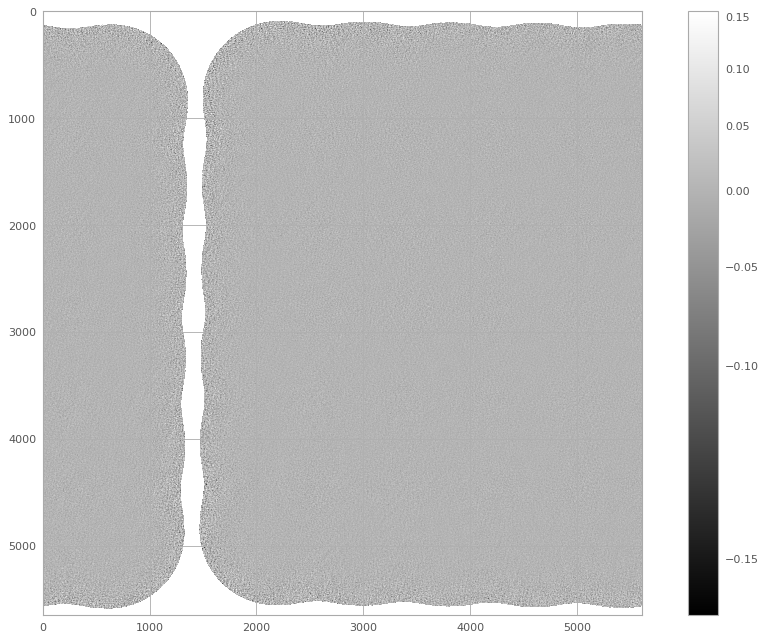

In [34]:
from astropy.utils.data import download_file
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
if True:
    #data.shape
    #data=data.reshape(data.shape[0], data.shape[3])
    plt.figure(figsize=(15,10), dpi= 80)
    #plt.subplot(projection=wcs, slices=('x', 'y', 0,6))
    plt.imshow(data, cmap='gray', norm=norm)
    plt.colorbar()

In [21]:
if True:
    MODE='append'
    FORMAT='parquet'
    TABLE='imagetestsparkfits'
    
    imageDF.write.mode(MODE).format(FORMAT).saveAsTable(TABLE)


In [22]:
if True:
    sqlContext.sql("""
    select spi_image
    from imagetestsparkfits
    where spi_index <=2591
    order by spi_index""").show()

+--------------------+
|           spi_image|
+--------------------+
|[[0.0, 0.0, 0.0, ...|
|[[0.0, 0.0, 0.0, ...|
|[[0.0, 0.0, 0.0, ...|
|[[0.0, 0.0, 0.0, ...|
|[[0.0, 0.0, 0.0, ...|
|[[0.0, 0.0, 0.0, ...|
|[[0.0, 0.0, 0.0, ...|
|[[0.0, 0.0, 0.0, ...|
|[[0.0, 0.0, 0.0, ...|
|[[0.0, 0.0, 0.0, ...|
|[[0.0, 0.0, 0.0, ...|
|[[0.0, 0.0, 0.0, ...|
|[[0.0, 0.0, 0.0, ...|
|[[0.0, 0.0, 0.0, ...|
|[[0.0, 0.0, 0.0, ...|
|[[0.0, 0.0, 0.0, ...|
|[[0.0, 0.0, 0.0, ...|
|[[0.0, 0.0, 0.0, ...|
|[[0.0, 0.0, 0.0, ...|
|[[0.0, 0.0, 0.0, ...|
+--------------------+
only showing top 20 rows



In [23]:
frequencyBandLength

5654

In [23]:
dff=imageDF.select(\
                   "spi_index", \
                   CastToFloatArrayUDF("spi_image").alias("spi_image"), \
                   lit(PartitionFileName).alias("spi_filename"), \
                   GetBandUDF("spi_index", lit(frequencyBandLength*spectraLength)).alias("spi_pol"),\
                   GetBandUDF("spi_index", lit(frequencyBandLength)).alias("spi_band") )\
.persist(StorageLevel.MEMORY_AND_DISK)

In [96]:
timer.start()
partitionTarget=df.rdd.getNumPartitions()
print("Source file partition numbers - {}".format(partitionTarget))

### Create the RDD with the zip index
imageRDD=rowdf_into_imagerdd(df)

print("RDD with zip index created")
timer.stop()

timer.start()
bRemoveNaNs=True

if bRemoveNaNs:
    print("Replacing NaN values with random float")
    PartitionFileName=PartitionFileName+'.NaNs.Removed'
    imageDF=imageRDD.map(lambda x: ( replace_nan_with_float(np.array(x[0]) ).tolist(), x[1] ) ).toDF(["spi_image","spi_index"])
else:
    imageDF=imageRDD.toDF(["spi_image","spi_index"])


numPartitions = imageDF.rdd.getNumPartitions()

if numPartitions < partitionTarget:
    imageDF=imageDF.repartition(partitionTarget)
    print("Repartitioning the dataframe from {} to {} partitions...".format(numPartitions, partitionTarget))

dff=imageDF.select(\
                   "spi_index", \
                   CastToFloatArrayUDF("spi_image").alias("spi_image"), \
                   lit(PartitionFileName).alias("spi_filename"), \
                   GetBandUDF("spi_index", lit(frequencyBandLength*spectraLength)).alias("spi_pol"),\
                   GetBandUDF("spi_index", lit(frequencyBandLength)).alias("spi_band") )\
.persist(StorageLevel.MEMORY_AND_DISK)

print("Dataframe created and persisted")

timer.stop()

Source file partition numbers - 6677
RDD with zip index created
Elapsed 1508.7s, CPU 1.3s
Replacing NaN values with random float


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 9.0 failed 4 times, most recent failure: Lost task 0.3 in stage 9.0 (TID 38288, hercules-2-2.nimbus.pawsey.org.au, executor 24): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/cloudera/parcels/SPARK2/lib/spark2/python/pyspark/worker.py", line 253, in main
    process()
  File "/opt/cloudera/parcels/SPARK2/lib/spark2/python/pyspark/worker.py", line 248, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/cloudera/parcels/SPARK2/lib/spark2/python/pyspark/serializers.py", line 379, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/cloudera/parcels/SPARK2/lib/spark2/python/pyspark/rdd.py", line 1352, in takeUpToNumLeft
    yield next(iterator)
  File "/opt/cloudera/parcels/SPARK2/lib/spark2/python/pyspark/util.py", line 55, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-96-1dbb444be03f>", line 17, in <lambda>
  File "<ipython-input-94-7e099962565d>", line 47, in replace_nan_with_float
IndexError: too many indices for array

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:330)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:470)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:453)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:284)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:152)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2074)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2074)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:381)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1651)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1639)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1638)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1638)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1872)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1821)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1810)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/cloudera/parcels/SPARK2/lib/spark2/python/pyspark/worker.py", line 253, in main
    process()
  File "/opt/cloudera/parcels/SPARK2/lib/spark2/python/pyspark/worker.py", line 248, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/cloudera/parcels/SPARK2/lib/spark2/python/pyspark/serializers.py", line 379, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/cloudera/parcels/SPARK2/lib/spark2/python/pyspark/rdd.py", line 1352, in takeUpToNumLeft
    yield next(iterator)
  File "/opt/cloudera/parcels/SPARK2/lib/spark2/python/pyspark/util.py", line 55, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-96-1dbb444be03f>", line 17, in <lambda>
  File "<ipython-input-94-7e099962565d>", line 47, in replace_nan_with_float
IndexError: too many indices for array

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:330)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:470)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:453)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:284)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:152)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2074)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2074)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:381)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [107]:
dff.printSchema()

root
 |-- spi_index: long (nullable = true)
 |-- spi_image: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- spi_filename: string (nullable = false)
 |-- spi_pol: integer (nullable = true)
 |-- spi_band: integer (nullable = true)



In [108]:
dff.registerTempTable("IMAGES")

In [111]:
sqlContext.sql("select spi_filename, spi_band from IMAGES").show(20, False)

+----------------------------------------+--------+
|spi_filename                            |spi_band|
+----------------------------------------+--------+
|residual.i.SB8170.cube.fits.NaNs.Removed|0       |
|residual.i.SB8170.cube.fits.NaNs.Removed|0       |
|residual.i.SB8170.cube.fits.NaNs.Removed|0       |
|residual.i.SB8170.cube.fits.NaNs.Removed|0       |
|residual.i.SB8170.cube.fits.NaNs.Removed|0       |
|residual.i.SB8170.cube.fits.NaNs.Removed|0       |
|residual.i.SB8170.cube.fits.NaNs.Removed|0       |
|residual.i.SB8170.cube.fits.NaNs.Removed|0       |
|residual.i.SB8170.cube.fits.NaNs.Removed|0       |
|residual.i.SB8170.cube.fits.NaNs.Removed|0       |
|residual.i.SB8170.cube.fits.NaNs.Removed|0       |
|residual.i.SB8170.cube.fits.NaNs.Removed|0       |
|residual.i.SB8170.cube.fits.NaNs.Removed|0       |
|residual.i.SB8170.cube.fits.NaNs.Removed|0       |
|residual.i.SB8170.cube.fits.NaNs.Removed|0       |
|residual.i.SB8170.cube.fits.NaNs.Removed|0       |
|residual.i.

In [109]:
sqlContext.sql("select spi_index, spi_image, spi_filename, spi_band from IMAGES").show(20)

+---------+--------------------+--------------------+--------+
|spi_index|           spi_image|        spi_filename|spi_band|
+---------+--------------------+--------------------+--------+
|        0|[0.0, 0.0, 0.0, 0...|residual.i.SB8170...|       0|
|        1|[0.0, 0.0, 0.0, 0...|residual.i.SB8170...|       0|
|        2|[0.0, 0.0, 0.0, 0...|residual.i.SB8170...|       0|
|        3|[0.0, 0.0, 0.0, 0...|residual.i.SB8170...|       0|
|        4|[0.0, 0.0, 0.0, 0...|residual.i.SB8170...|       0|
|        5|[0.0, 0.0, 0.0, 0...|residual.i.SB8170...|       0|
|        6|[0.0, 0.0, 0.0, 0...|residual.i.SB8170...|       0|
|        7|[0.0, 0.0, 0.0, 0...|residual.i.SB8170...|       0|
|        8|[0.0, 0.0, 0.0, 0...|residual.i.SB8170...|       0|
|        9|[0.0, 0.0, 0.0, 0...|residual.i.SB8170...|       0|
|       10|[0.0, 0.0, 0.0, 0...|residual.i.SB8170...|       0|
|       11|[0.0, 0.0, 0.0, 0...|residual.i.SB8170...|       0|
|       12|[0.0, 0.0, 0.0, 0...|residual.i.SB8170...|  

Write the dataframe into the target table.

Check the polarisations. If there is only one polarisation, we can ignore that and insert into the sparkfits_images table; otherwise we insert into sparkfits_polarised_images.

In [22]:
sqlContext.sql("show tables").show()

+------------------+--------------------+-----------+
|          database|           tableName|isTemporary|
+------------------+--------------------+-----------+
|fits_investigation|          array_test|      false|
|fits_investigation|          float_test|      false|
|fits_investigation|   localparalleltest|      false|
|fits_investigation|localparalleltest...|      false|
|fits_investigation|localparalleltest...|      false|
|fits_investigation|localparalleltest...|      false|
|fits_investigation|parquetpartitione...|      false|
|fits_investigation|parquetpartitione...|      false|
|fits_investigation|parquetpartitione...|      false|
|fits_investigation|parquetpartitione...|      false|
|fits_investigation|parquetpartitione...|      false|
|fits_investigation|parquetpartitione...|      false|
|fits_investigation|parquetpartitione...|      false|
|fits_investigation|parquetpartitione...|      false|
|fits_investigation|parquetpartitione...|      false|
|fits_investigation|parquetu

In [ ]:
print("Writing dataframe to parquet images table")
timer.start()
if polarisation==1:
    print("Saving to sparkfits_images")
    sqlContext.sql("""
    insert overwrite table sparkfits_images partition(spi_filename, spi_band ) 
    select spi_index, spi_image, spi_filename, spi_band from IMAGES
    """)
else:
    print("Saving to sparkfits_polarised_images")
    sqlContext.sql("""
    insert overwrite table sparkfits_polarised_images partition(spi_filename, spi_pol, spi_band ) 
    select spi_index, spi_image, spi_filename, spi_pol, spi_band from IMAGES
    """)

print("All done!")
timer.stop()

Writing dataframe to parquet images table
Saving to sparkfits_images


## new dimension table testing

In [17]:
for i, c in enumerate([cubeHz]):
    timer.start()
    print(c.header["ORIGIN"])

    cubePixelValue = c.header["BUNIT"]
    cubeRaDim = c.header["NAXIS1"]
    cubeDecDim = c.header["NAXIS2"]
    cubeSpectraDim = c.header["NAXIS3"]
    cubeRACoordinate = c.header["CTYPE1"]
    cubeDecCoordinate = c.header["CTYPE2"]
    cubeSpectraCoordinate = c.header["CTYPE3"]
    cubeRAUnits = c.header["CUNIT1"]
    cubeDecUnits = c.header["CUNIT2"]
    cubeSpectraUnits = c.header["CUNIT3"]
    print(cubePixelValue, cubeSpectraCoordinate, cubeSpectraUnits)
    timer.start()

    ra, dec, specArray, DecDF = FastGetCubePositions(c, PartitionFileName, cubeDecCoordinate, cubeSpectraUnits, cubeDecDim)


ASKAPSoft
beam-1 Jy FREQ Hz
arrays created
and parallelized
dataframe created


In [18]:
DecDF.registerTempTable("POSDIM")

In [19]:
sqlContext.sql("""select * from POSDIM""").show()

+---------+-----------------+---------------+--------------------+-----------------+----------------+--------+
|spd_index|spd_spectra_value|spd_declination|        spd_filename|spd_position_type|spd_spectra_type|spd_band|
+---------+-----------------+---------------+--------------------+-----------------+----------------+--------+
|        0|     1.37649997E9|      -42.05753|image.restored.i....|         DEC--SIN|              Hz|       0|
|        1|     1.37649997E9|      -42.05864|image.restored.i....|         DEC--SIN|              Hz|       0|
|        2|     1.37649997E9|      -42.05975|image.restored.i....|         DEC--SIN|              Hz|       0|
|        3|     1.37649997E9|      -42.06086|image.restored.i....|         DEC--SIN|              Hz|       0|
|        4|     1.37649997E9|      -42.06197|image.restored.i....|         DEC--SIN|              Hz|       0|
|        5|     1.37649997E9|      -42.06308|image.restored.i....|         DEC--SIN|              Hz|       0|
|

In [20]:
newPosDimDF=sqlContext.sql("""
    with myData as
    (
    select
    spd_filename,spd_position_type,spd_spectra_type,
    spd_declination,
        map(
            'idxVal', spd_index
        ) as kv
        from POSDIM
        distribute by spd_declination
        sort by spd_index
    )
    select
    spd_filename,spd_position_type,spd_spectra_type,
    spd_declination,
    collect_list( float(a.kv['idxVal']) ) as spd_declination_spectra 
    from myData a
    group by spd_filename,spd_position_type,spd_spectra_type,spd_declination
    order by spd_declination desc

""")

In [21]:
newPosDimDF.printSchema()

root
 |-- spd_filename: string (nullable = false)
 |-- spd_position_type: string (nullable = false)
 |-- spd_spectra_type: string (nullable = false)
 |-- spd_declination: float (nullable = true)
 |-- spd_declination_spectra: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [22]:
newPosDimDF.registerTempTable('NewPosDim')

In [23]:
sqlContext.sql("""
select spd_declination,spd_declination_spectra,
spd_filename,spd_position_type,spd_spectra_type
from NewPosDim
""").show()

+---------------+-----------------------+--------------------+-----------------+----------------+
|spd_declination|spd_declination_spectra|        spd_filename|spd_position_type|spd_spectra_type|
+---------------+-----------------------+--------------------+-----------------+----------------+
|      -42.05753|   [0.0, 5654.0, 113...|image.restored.i....|         DEC--SIN|              Hz|
|      -42.05864|   [1.0, 5655.0, 113...|image.restored.i....|         DEC--SIN|              Hz|
|      -42.05975|   [2.0, 5656.0, 113...|image.restored.i....|         DEC--SIN|              Hz|
|      -42.06086|   [3.0, 5657.0, 113...|image.restored.i....|         DEC--SIN|              Hz|
|      -42.06197|   [4.0, 5658.0, 113...|image.restored.i....|         DEC--SIN|              Hz|
|      -42.06308|   [5.0, 5659.0, 113...|image.restored.i....|         DEC--SIN|              Hz|
|     -42.064194|   [6.0, 5660.0, 113...|image.restored.i....|         DEC--SIN|              Hz|
|     -42.065304|   

In [24]:
sqlContext.sql("""
insert overwrite table sparkfits_new_position_dimension
partition(spd_filename, spd_position_type, spd_spectra_type) 
select spd_declination,spd_declination_spectra,
spd_filename,spd_position_type,spd_spectra_type
from NewPosDim
""")

DataFrame[]

In [57]:
sqlContext.sql("""select * from sparkfits_new_position_dimension
where spd_declination < -18.2
and spd_declination >= -22.2
order by spd_declination desc""").show()

+---------------+-----------------------+--------------------+-----------------+----------------+
|spd_declination|spd_declination_spectra|        spd_filename|spd_position_type|spd_spectra_type|
+---------------+-----------------------+--------------------+-----------------+----------------+
|     -18.200047|   [60.0, 5410.0, 10...|residual.i.SB8170...|         DEC--SIN|              Hz|
|     -18.201717|   [61.0, 5411.0, 10...|residual.i.SB8170...|         DEC--SIN|              Hz|
|     -18.203386|   [62.0, 5412.0, 10...|residual.i.SB8170...|         DEC--SIN|              Hz|
|     -18.205055|   [63.0, 5413.0, 10...|residual.i.SB8170...|         DEC--SIN|              Hz|
|     -18.206726|   [64.0, 5414.0, 10...|residual.i.SB8170...|         DEC--SIN|              Hz|
|     -18.208395|   [65.0, 5415.0, 10...|residual.i.SB8170...|         DEC--SIN|              Hz|
|     -18.210064|   [66.0, 5416.0, 10...|residual.i.SB8170...|         DEC--SIN|              Hz|
|     -18.211735|   

In [58]:
sqlContext.sql("""select max(spd_declination_spectra[14]) , min(spd_declination_spectra[14]) 
from sparkfits_new_position_dimension
where spd_declination < -18.2
and spd_declination >= -22.2
""").show()

+--------------------------------+--------------------------------+
|max(spd_declination_spectra[14])|min(spd_declination_spectra[14])|
+--------------------------------+--------------------------------+
|                         77359.0|                         74960.0|
+--------------------------------+--------------------------------+



In [61]:
sqlContext.sql("""select * from sparkfits_images where spi_index >=74960 and spi_index <=77359
and spi_filename='residual.i.SB8170.cube.fits'
and spi_band=14""").count()

2400

In [64]:
sqlContext.sql("""
with positions as
(
    select max(spd_declination_spectra[17]) as maxIdx, min(spd_declination_spectra[17]) as minIdx
    from sparkfits_new_position_dimension
    where spd_declination < -18.2
    and spd_declination >= -22.2
)
select a.* 
from sparkfits_images a
    cross join positions b
where spi_index >=b.minIdx and spi_index <=b.maxIdx
and spi_filename='residual.i.SB8170.cube.fits'
and spi_band=17
""").show()

+---------+--------------------+--------------------+--------+
|spi_index|           spi_image|        spi_filename|spi_band|
+---------+--------------------+--------------------+--------+
|    91010|[NaN, NaN, NaN, N...|residual.i.SB8170...|      17|
|    91011|[NaN, NaN, NaN, N...|residual.i.SB8170...|      17|
|    91012|[NaN, NaN, NaN, N...|residual.i.SB8170...|      17|
|    91013|[NaN, NaN, NaN, N...|residual.i.SB8170...|      17|
|    91014|[NaN, NaN, NaN, N...|residual.i.SB8170...|      17|
|    91015|[NaN, NaN, NaN, N...|residual.i.SB8170...|      17|
|    91016|[NaN, NaN, NaN, N...|residual.i.SB8170...|      17|
|    91017|[NaN, NaN, NaN, N...|residual.i.SB8170...|      17|
|    91018|[NaN, NaN, NaN, N...|residual.i.SB8170...|      17|
|    91019|[NaN, NaN, NaN, N...|residual.i.SB8170...|      17|
|    91020|[NaN, NaN, NaN, N...|residual.i.SB8170...|      17|
|    91021|[NaN, NaN, NaN, N...|residual.i.SB8170...|      17|
|    91022|[NaN, NaN, NaN, N...|residual.i.SB8170...|  

## Dimension Table Population

Create the function that will populate the detail arrays table

In [24]:
def CreateAndSaveArrays(array, filename, arrayCoordinates, cubeSpectraUnits=None ):
    if cubeSpectraUnits == None:
        sda_detail_name=arrayCoordinates
    else:
        sda_detail_name=cubeSpectraUnits

    #logger.in(filename, sda_detail_name )

    arrayRDD=sc.parallelize(array).zipWithIndex().map(lambda x :(x[1], x[0]) )
    arrayDF=arrayRDD.map(lambda x: (x[0], x[1].tolist()) ).toDF(["index", "spectra"])

    #"""
    #
    # Maintaining order within a collect_list, See
    # https://stackoverflow.com/questions/50766764/sorting-within-collect-list-in-hive
    #
    #"""

    arrayDF.registerTempTable("SPECTRAS")

    sqlStmt="""
    with myData as
    (
        select 1 as grp,
        index as idx,
        map(
            'spectraVal', spectra
        ) as kv
        from SPECTRAS
        distribute by grp
        sort by grp, index
    )
    select collect_list( float(a.kv['spectraVal']) ) as sda_detail_array 
    from myData a
    group by grp
    """

    spectraArrayDF=sqlContext.sql(sqlStmt)
    spectraArrayDF=spectraArrayDF.select("sda_detail_array"\
                                         ,lit(filename).alias("sda_filename")\
                                         ,lit(sda_detail_name).alias("sda_detail_type"))

    spectraArrayDF.registerTempTable("ARRAYS")
    sqlContext.sql("""
    insert overwrite table sparkfits_detail_arrays 
    partition(sda_filename , sda_detail_type) 
    select sda_detail_array, sda_filename, sda_detail_type
    from ARRAYS
    """)



In [25]:
print("Populating the dimension tables")

timer.start()
print("Create the alternative spectral cubes for the differing spectral arrays")
cubeVel = cubeHz.with_spectral_unit(u.km / u.s, velocity_convention='radio' ,rest_value=200 * u.Hz)
cubeGHz = cubeHz.with_spectral_unit(u.GHz, velocity_convention='radio' ,rest_value=200 * u.GHz)
print("Alternative cubes created")
timer.stop()


Populating the dimension tables
Create the alternative spectral cubes for the differing spectral arrays
Alternative cubes created
Elapsed 0.1s, CPU 0.1s


In [18]:
cubeHz

SpectralCube with shape=(7776, 5350, 5385) and unit=Jy / pix:
 n_x:   5385  type_x: RA---SIN  unit_x: deg    range:    49.143964 deg:   59.229743 deg
 n_y:   5350  type_y: DEC--SIN  unit_y: deg    range:   -27.019640 deg:  -18.099758 deg
 n_s:   7776  type_s: FREQ      unit_s: Hz     range: 1295500000.000 Hz:1439481481.481 Hz

In [26]:
#for i, c in enumerate([cubeHz, cubeVel, cubeGHz]):
for i, c in enumerate([cubeVel, cubeVel, cubeGHz]):
    timer.start()
    print(c.header["ORIGIN"])

    cubePixelValue = c.header["BUNIT"]
    cubeRaDim = c.header["NAXIS1"]
    cubeDecDim = c.header["NAXIS2"]
    cubeSpectraDim = c.header["NAXIS3"]
    cubeRACoordinate = c.header["CTYPE1"]
    cubeDecCoordinate = c.header["CTYPE2"]
    cubeSpectraCoordinate = c.header["CTYPE3"]
    cubeRAUnits = c.header["CUNIT1"]
    cubeDecUnits = c.header["CUNIT2"]
    cubeSpectraUnits = c.header["CUNIT3"]
    print(cubePixelValue, cubeSpectraCoordinate, cubeSpectraUnits)
    timer.start()

    ra, dec, specArray, DecDF = FastGetCubePositions(c, PartitionFileName, cubeDecCoordinate, cubeSpectraUnits, cubeDecDim)

    """
    Add the declination and frequency dimension to the table
    """
    print("Creating the temp table POSDIM and writing the data into the dimension table")

    DecDF.registerTempTable("POSDIM")
    sqlContext.sql("""
    insert overwrite table sparkfits_position_dimension 
    partition(spd_filename, spd_position_type, spd_spectra_type, spd_band) 
    select spd_index, spd_spectra_value, spd_declination,
    spd_filename,spd_position_type,spd_spectra_type,spd_band
    from POSDIM
    """)

    if i == 0:
        print("Creating ra and dec detail arrays")
        CreateAndSaveArrays(ra,  PartitionFileName, cubeRACoordinate)
        CreateAndSaveArrays(dec, PartitionFileName, cubeDecCoordinate)

    print("Creating the spectral detail array")
    CreateAndSaveArrays(specArray, PartitionFileName, cubeSpectraCoordinate, cubeSpectraUnits) 
    timer.stop()

ASKAPSoft
beam-1 Jy VRAD km s-1
arrays created
and parallelized
dataframe created
Creating the temp table POSDIM and writing the data into the dimension table
Creating ra and dec detail arrays
Creating the spectral detail array
Elapsed 552.1s, CPU 5.4s
ASKAPSoft
beam-1 Jy VRAD km s-1
arrays created
and parallelized
dataframe created
Creating the temp table POSDIM and writing the data into the dimension table
Creating the spectral detail array
Elapsed 563.4s, CPU 5.3s
ASKAPSoft
beam-1 Jy FREQ GHz
arrays created
and parallelized
dataframe created
Creating the temp table POSDIM and writing the data into the dimension table
Creating the spectral detail array
Elapsed 547.2s, CPU 5.2s
